# End to End Optical Music Recognition with CRNN

In [ ]:
%load_ext tensorboard

## Importing libraries

In [1]:
# TODO: Cleanup imports

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed
# tf.compat.v1.disable_eager_execution()
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Layer
# from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, Permute, Bidirectional
# from tensorflow.keras.layers import Reshape, Lambda, BatchNormalization, LSTM
# from tensorflow.python.keras.layers.merge import add, concatenate
# from tensorflow.python.keras.layers.recurrent import LSTM
# from tensorflow.keras.layers import CuDNNLSTM
from primus import CTC_PriMuS
import ctc_utils
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

import jiwer
import datetime

In [2]:
tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

## Loading Dataset

In [1]:
CORPUS_DIRPATH = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/primusCalvoRizoAppliedSciences2018/"
CORPUS_FILEPATH = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/train.txt"
TEST_SET_PATH = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/test.txt"
DICTIONARY_PATH = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/vocabulary_semantic.txt"

In [7]:
# # delete N lines from the train/test txt files for training purposes
# with open(r"C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/train.txt", 'r+') as fp:
#     lines = fp.readlines()
#     t = int(len(lines))
#     print(t)
#     # print(len(lines))
#     fp.seek(0)
#     fp.truncate()
#     fp.writelines(lines[:-200])

In [8]:
# Get Data
image_paths = []
image_texts = []

class PriMuS_Data:
    def __init__(self, corpus_dirpath, corpus_filepath, test_set_filepath, dictionary_path):
        self.corpus_dirpath = corpus_dirpath

        # Corpus
        corpus_file = open(corpus_filepath,'r')
        self.corpus_list = corpus_file.read().splitlines()
        corpus_file.close()

        # Test set
        test_set_file = open(test_set_filepath,'r')
        self.test_set_list = test_set_file.read().splitlines()
        test_set_file.close()

        # Vocabulary
        self.word2int = {}
        self.int2word = {}
            
        dict_file = open(dictionary_path,'r')
        dict_list = dict_file.read().splitlines()
        for word in dict_list:
            if not word in self.word2int:
                word_idx = len(self.word2int)
                self.word2int[word] = word_idx
                self.int2word[word_idx] = word

        dict_file.close()
        self.vocabulary_size = len(self.word2int)
        self.vocabulary = {"int2word": self.int2word, "word2int": self.word2int}

    def generate_dataset(self, val_split = 0.9):
        image_paths = [self.corpus_dirpath+f"{x}/{x}.png" for x in self.corpus_list] 
        text_paths = [self.corpus_dirpath+f"{x}/{x}.semantic" for x in self.corpus_list]

        test_image_paths = [self.corpus_dirpath+f"{x}/{x}.png" for x in self.test_set_list] 
        test_text_paths = [self.corpus_dirpath+f"{x}/{x}.semantic" for x in self.test_set_list]

        train_image_paths = image_paths[ : int(len(image_paths) * val_split)]
        val_image_paths = image_paths[int(len(image_paths) * val_split) : ]

        train_text_paths = text_paths[ : int(len(text_paths) * val_split)]
        val_text_paths = text_paths[int(len(text_paths) * val_split) : ]

        # Generating metadata
        self.max_image_width = 0
        self.max_label_len = 0

        for img in image_paths + test_image_paths:
            width = cv2.imread(img).shape[1]
            if width > self.max_image_width:
                self.max_image_width = width

        for path in text_paths + test_text_paths:
            with open(path, "r") as file:
                label_len = len(file.readline().split())
                if label_len > self.max_label_len:
                    self.max_label_len = label_len
        
        metadata = {"metadata":{"max_label_len":self.max_label_len,
                                "max_image_width":self.max_image_width}
        }
        
        data = {"train": {"images":train_image_paths, "text": train_text_paths}, 
                "val":   {"images":val_image_paths, "text": val_text_paths}, 
                "test":  {"images":test_image_paths, "text": test_text_paths}
        }

        return {**data, **metadata}

    # Encodes single sample
    def encoder(self, seq): # "clef\tC-note" -> [1,2,3,4,..]
        new_seq=[]
        for sym in seq:
            new_seq.append(self.word2int[sym])
        return new_seq

    def decoder(self, seq): # [1,2,3,4,..] -> "clef\tC-note"
        new_seq=""
        for sym in seq:
            try:
                new_seq+= self.int2word[sym] + "\t"
            except KeyError:
                continue
        new_seq = new_seq[:-1]
        return new_seq

    # Encodes multiple samples
    def encode_seqs(self, seqs):
        encoded = []
        for seq in seqs:
            encoded.append(self.encoder(seq))
        return encoded

    def decode_seqs(self, seqs): 
        decoded = []
        for seq in seqs:
            decoded.append(self.decoder(seq))
        return decoded

    # Converts predictions into string sequences
    def prediction_decoder(self, preds):
        # TODO: softmax here?
        pred_indcies = np.argmax(preds, axis=2)
        decoded_pred = self.decode_seqs(pred_indcies)
        return decoded_pred

    def ground_truth_decoder(self, truths):
        # TODO: Read values from filepath
        return self.decode_seqs(truths)

In [9]:
data_obj = PriMuS_Data(CORPUS_DIRPATH, CORPUS_FILEPATH, TEST_SET_PATH, DICTIONARY_PATH)
data = data_obj.generate_dataset()

56


## Building the model

### Model Parameters

In [3]:
def default_model_params(img_height, vocabulary_size):
    params = dict()
    params['img_height'] = img_height
    params['img_width'] = None
    params['batch_size'] = 16
    params['img_channels'] = 1
    params['conv_blocks'] = 2
    params['conv_filter_n'] = [32, 64]
    params['conv_filter_size'] = [ [3,3], [3,3] ]
    params['conv_pooling_size'] = [ [2,2], [2,2] ]
    params['rnn_units'] = 32
    params['rnn_layers'] = 1
    params['vocabulary_size'] = vocabulary_size
    return params

### Custom CTC Loss Layer

In [4]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost
        # self.loss_fn = K.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64") # 16
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

### Evaluation functions

In [ ]:
def ser(y_true, y_pred):
    y_true = data_obj.ground_truth_decoder([y_true])[0]
    y_true = jiwer.RemoveWhiteSpace(replace_by_space=True)(y_true)
    y_pred = jiwer.RemoveWhiteSpace(replace_by_space=True)(y_pred)
    error = jiwer.wer(y_true, y_pred)
    return error

def symbol_accurary(y_true, y_pred):
    return 1-ser(y_true, y_pred)

### Model

In [5]:
def build_model(params, input_width, rnn_layers = 2, rnn_units = 128, dropout_rate=0.35):
    input_shape = (params['img_height'],params['img_width'], params['img_channels'])

    inputs = layers.Input(type_spec=tf.TensorSpec(shape=[None, params['img_height'], input_width, 1], dtype=tf.float32), name = "image" )
    # inputs = layers.Input(name='image', shape=input_shape, dtype='float32')

    labels = layers.Input(type_spec=tf.TensorSpec(shape=[None, None], dtype=tf.float32), name = "label" )
    # x = layers.Reshape((params['img_height'], input_width, 1), name="expand_dim")(inputs)
    x = layers.Conv2D(
        filters=32,
        kernel_size= [params['conv_filter_n'][0], params['conv_filter_n'][0]],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(inputs)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.MaxPool2D(pool_size=params['conv_pooling_size'][0], strides = params['conv_pooling_size'][0], name='max1')(x)

    x = layers.Conv2D(
        filters=64,
        kernel_size=[params['conv_filter_n'][1], params['conv_filter_n'][1]],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.MaxPool2D(pool_size=params['conv_pooling_size'][1], strides = params['conv_pooling_size'][1], name='max2')(x)
    print(x.shape)

    # TODO: Check if reshaping is correct
    x = layers.Reshape((-1, x.shape[-3] * x.shape[-1]))(x)

    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=dropout_rate)(x)

    num_classes = params['vocabulary_size'] + 1
    y_pred = layers.Dense(num_classes, kernel_initializer='he_normal',name='dense2', activation='softmax')(x) #(None, 32, 63)        

    output = CTCLayer(name="ctc_loss")(labels, y_pred)
    model = Model([inputs,labels], output, name="OMR")

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    model.compile(optimizer = optimizer)
    # TODO: add val_loss, accuracy, val_accuracy
    # TODO: insert SER here
    # https://keras.io/api/models/model_training_apis/
    # model.compile(optimizer=opt, loss=CTCLoss) 
    return model

### Initializing Model

In [ ]:
# Parameters
IMG_HEIGHT = 128
DROPOUT_RATE = 0.5 # or 0.35

params = default_model_params(IMG_HEIGHT, data_obj.vocabulary_size)

# Model
model = build_model(params, input_width = data_obj.max_image_width, dropout_rate = DROPOUT_RATE)

In [12]:
model.summary()

2003
(None, 16, 125, 64)
Model: "OMR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 2003,   0           []                               
                                1)]                                                               
                                                                                                  
 conv_1 (Conv2D)                (None, 64, 1002, 32  32768       ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 conv_1_bn (BatchNormalization)  (None, 64, 1002, 32  128        ['conv_1[0][0]']                 
                                )                                      

c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Preprocessing data for training

In [ ]:
# Pre-process a single image sample(resize/normalize/max_width resize)
def process_single_sample(img_path, label):
    # Reading image
    img = tf.io.read_file(img_path) 
    img = tf.io.decode_png(img, channels=1) # Decoding and convert to grayscale
    img = tf.image.convert_image_dtype(img, tf.float32) # Converting to float32 in [0, 1] range
    img = tf.image.resize(img,[params['img_height'], data_obj.max_image_width]) # Resizing 

    # Reading text file
    with open(label, "r") as file: 
        label = file.readline().split()
        image_text = data_obj.encoder(label)
        padded_image_text = pad_sequences([image_text], 
                                          maxlen = data_obj.max_label_len, 
                                          padding ='post', 
                                          value = data_obj.vocabulary_size + 1)
        label = padded_image_text[0]
    return {"image": img, "label": label}

# Data generator
def tfdata_generator(data, batch_size=params['batch_size']):
  '''Construct a data generator using `tf.Dataset`. '''
  dataset = tf.data.Dataset.from_tensor_slices((data['images'], data['text']))
  dataset = dataset.map(process_single_sample)
  dataset = dataset.batch(batch_size)
  # train_dataset = train_dataset.repeat()
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [13]:
train_dataset = tfdata_generator(data["train"])
validation_dataset = tfdata_generator(data["val"])
test_dataset = tfdata_generator(data["test"])

## Training the model

In [ ]:
EPOCHS = 500
MAX_EPOCHS = 100 # FIXME: Not being used

In [14]:
log_dir = "../data/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/model500.ckpt', save_weights_only=True, save_best_only = True , verbose= 1),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
]

In [15]:
# FIXME: Find out why validation data is not being used

# history = model.fit(
#     train_dataset,
#     # tf.compat.v1.data.make_one_shot_iterator(train_dataset).get_next(),
#     # validation_data = tf.compat.v1.data.make_one_shot_iterator(validation_dataset).get_next(),
#     validation_data = validation_dataset,
#     epochs=EPOCHS,
#     callbacks=my_callbacks
# )

# model.save_weights()

In [16]:
# Save model
# model.save_weights("../models/model_500epoch.ckpt")

### Tensorboard

In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
# !tensorboard dev upload \
#   --logdir logs/fit \
#   --name "DL OMR" \
#   --description "Optical Music Recognition with CRNN" \
#   --one_shot

In [ ]:
# TODO: https://www.tensorflow.org/tensorboard/image_summaries

### Loading the model

In [17]:
# Load model
model.load_weights("../models/model500.ckpt")

In [18]:
# new_model = tf.keras.models.load_model('../models/model.01-105.60.h5', custom_objects={'CTCLayer': CTCLayer})
# new_model = tf.keras.models.load_model('../models/model_1epoch.hdf5', custom_objects={'CTCLayer': CTCLayer})

In [19]:
# Loading Model
# model = tf.keras.models.load_model('../models/model.01-105.60.h5', custom_objects={'CTCLayer': CTCLayer})
# Loading Weights

## Predicting on test data

In [21]:
ground_truth = data["test"]["text"]
print(data_obj.ground_truth_decoder(ground_truth)[0])

clef-C1	keySignature-EbM	timeSignature-2/4	multirest-23	barline	rest-quarter	rest-eighth	note-Bb4_eighth	barline	note-Bb4_quarter.	note-G4_eighth	barline	note-Eb5_quarter.	note-D5_eighth	barline	note-C5_eighth	note-C5_eighth	rest-quarter	barline


In [22]:
preds = model.predict(test_dataset)
pred_strings = data_obj.prediction_decoder(preds)
pred_strings

['clef-C1\tkeySignature-DM\ttimeSignature-3/8\tmultirest-11\tbarline\trest-quarter\trest-quarter\tbarline',
 'clef-C1\tkeySignature-BbM\ttimeSignature-C\tmultirest-5\tbarline\tbarline\trest-quarter\tbarline\tbarline',
 'clef-C4\tkeySignature-BbM\ttimeSignature-C\tmultirest-8\tbarline\trest-quarter\tbarline',
 'clef-G2\tkeySignature-AM\ttimeSignature-2/4\tbarline',
 'clef-C1\tkeySignature-EbM\ttimeSignature-C\tmultirest-4\tbarline\tbarline\tbarline\tbarline\tbarline\tbarline\tbarline\tbarline\tbarline',
 'clef-C1\ttimeSignature-C\trest-eighth\trest-eighth\trest-eighth',
 'clef-G2\tkeySignature-GM\ttimeSignature-C\tbarline\tnote-A5_quarter\tnote-A5_quarter\tnote-A5_quarter\tnote-A5_quarter\tnote-A5_quarter\tnote-G5_quarter',
 'clef-G2\tkeySignature-EbM\ttimeSignature-C\tmultirest-4\tbarline\trest-half\tbarline',
 'clef-C1\tkeySignature-EbM\ttimeSignature-C\tmultirest-8\tbarline\tbarline\trest-quarter\tbarline\tbarline',
 'clef-G2\tkeySignature-FM\ttimeSignature-C\tbarline',
 'clef-C3\tke

## Evaluating the model

In [ ]:
def plot_sample():
    pass

### Average Error Rate and Accuracy

### Best samples

### Worst samples

### Clean up below

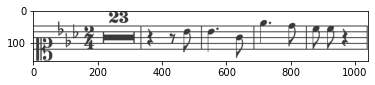

clef-C1	keySignature-EbM	timeSignature-2/4	multirest-23	barline	rest-quarter	rest-eighth	note-Bb4_eighth	barline	note-Bb4_quarter.	note-G4_eighth	barline	note-Eb5_quarter.	note-D5_eighth	barline	note-C5_eighth	note-C5_eighth	rest-quarter	barline

 clef-C1	keySignature-DM	timeSignature-3/8	multirest-11	barline	rest-quarter	rest-quarter	barline

Word Error Rate is :  1.0


In [23]:
def plot_predict(data, pred_strings, index):
    images = data["images"][index]
    ground_truth = data["text"]
    ground_truth = data_obj.ground_truth_decoder(ground_truth)[index]
    # [index]
    predictions = pred_strings[index]
    plot = cv2.imread(images)
    plt.imshow(plot)
    plt.show()
    print(ground_truth)
    print("\n",predictions)
    # return plot

plot_predict(data["test"],pred_strings, 0)
error = jiwer.wer(data_obj.ground_truth_decoder(ground_truth), pred_strings)
print("\nWord Error Rate is : ", error)

In [35]:
pred_strings1 = pred_strings
ground_truth1 = ground_truth
pred_strings1 = jiwer.RemoveWhiteSpace(replace_by_space=True)(pred_strings1)
ground_truth1 = jiwer.RemoveWhiteSpace(replace_by_space=True)(data_obj.ground_truth_decoder(ground_truth1))
error = jiwer.wer(ground_truth1[0], pred_strings1[0])
print(error)

0.7368421052631579


In [33]:
#separating it into words didnt work because they dont have the same size
# pred_strings1 = pred_strings
# ground_truth1 = ground_truth
# pred_strings1 = jiwer.ReduceToListOfListOfWords(word_delimiter="\t")(pred_strings1)
# ground_truth1 = jiwer.ReduceToListOfListOfWords(word_delimiter="\t")(ground_truth_decoder(ground_truth1))
# error = wer(ground_truth1[0], pred_strings1[0])
# print(error)

ValueError: number of ground truth inputs (19) and hypothesis inputs (8) must match.